## Extracting Chess Squares with Square Filling Algorithm ( image --> fen format)

<br>
<font size="4">
Notebook version of square_filling.py file. You can use this file for testing 
</font>
<br><br><br><br>

<br>

## Necessary Libraries

In [140]:
import cv2
import numpy as np
import matplotlib.pyplot as plt 
import  math


In [141]:
def sort_quadrilateral_approx(approx):
    '''
    returns (bottomright(1), topright(2) , topleft(3) , bottomleft(4))
    '''

    # create same pattern for points , bottomright(1) , topright(2) , topleft(3) , bottomleft(4)
    index_sorted = sorted(approx, key=lambda x: x[0], reverse=True)
    #  Y values
    if index_sorted[0][1]< index_sorted[1][1]:
        index_sorted[0], index_sorted[1] = index_sorted[1], index_sorted[0]

    if index_sorted[2][1]> index_sorted[3][1]:
        index_sorted[2], index_sorted[3] = index_sorted[3], index_sorted[2]

    # bottomright(1) , topright(2) , topleft(3) , bottomleft(4)
    return (index_sorted[0], index_sorted[1], index_sorted[2], index_sorted[3])

In [142]:
image_path =  r"E:\projects\uni\Chessy3D\data\chessred\images\0\G000_IMG004.jpg"
image_path = r"C:\Users\Alessandro\Downloads\Immagine WhatsApp 2025-06-01 ore 22.59.14_ef4809cb.jpg"
image_path = r"C:\Users\Alessandro\Downloads\Immagine WhatsApp 2025-06-01 ore 22.59.14_5b4da136.jpg"
image_path = r"C:\Users\Alessandro\Downloads\Dynamic-Chess-Board-Piece-Extraction-master\Dynamic-Chess-Board-Piece-Extraction-master\test-images\test-8.jpeg"
image_path = r"C:\Users\Alessandro\Downloads\Dynamic-Chess-Board-Piece-Extraction-master\Dynamic-Chess-Board-Piece-Extraction-master\test-images\test-15.jpeg"
# image_path =  r"E:\projects\uni\Chessy3D\data\chessred\images\38\G038_IMG099.jpg" # troppo inclinata
# image_path =  r"E:\projects\uni\Chessy3D\data\chessred\images\41\G041_IMG019.jpg" # troppo inclinata
image_path =  r"E:\projects\uni\Chessy3D\data\chessred\images\42\G042_IMG054.jpg" # troppo inclinata
image_path = r"E:\projects\uni\Chessy3D\data\chessred\images\0\G000_IMG007.jpg"
image_path = r"E:\projects\uni\Chessy3D\data\chessred\images\0\G000_IMG016.jpg"
image_path = r"E:\projects\uni\Chessy3D\data\chessred\images\15\G015_IMG006.jpg"

# image_path =  r"E:\projects\uni\Chessy3D\data\chessred\images\33\G033_IMG069.jpg"


Candidates 1
[(array([2950, 2304], dtype=int32), array([2135,  519], dtype=int32), array([138, 748], dtype=int32), array([ 485, 2881], dtype=int32))]


Text(0.5, 1.0, 'RGB')

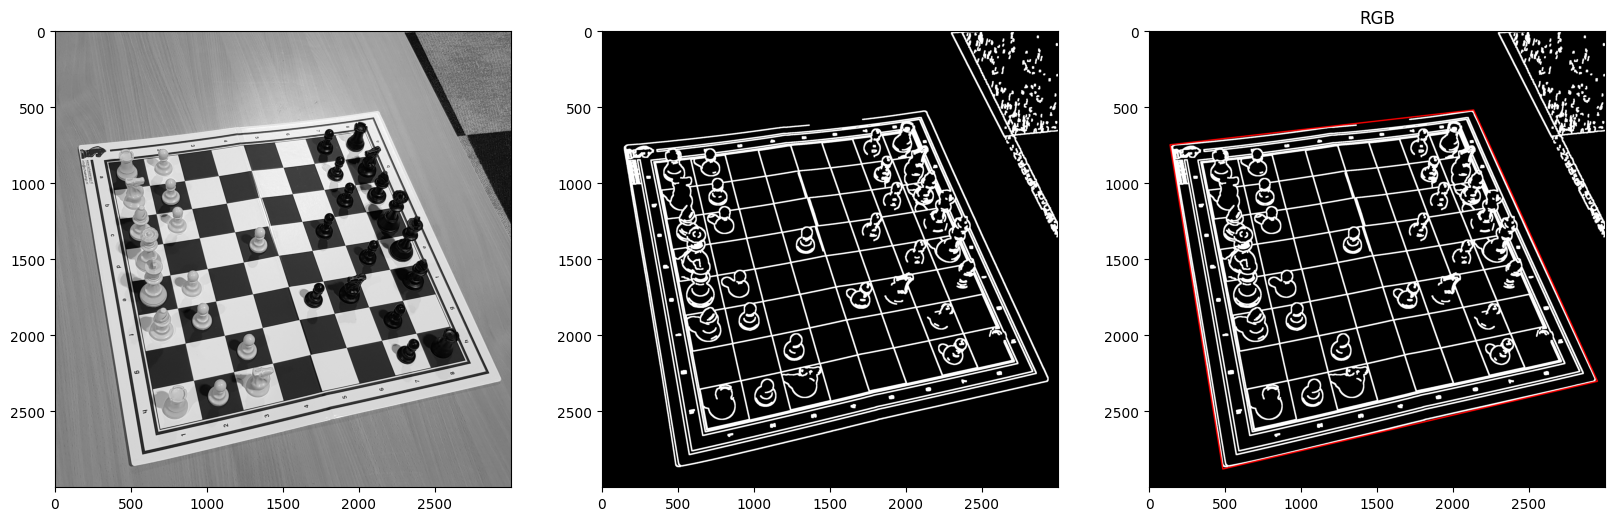

In [143]:
# Path of Image that you want to convert

# read image and convert it to different color spaces
image = cv2.imread(image_path)
resized = cv2.resize(image, (3000, 3000))

original_size = image.shape[0]
resized_size = 3000
parameters_original_size = 1000
upsize_factor = resized_size / original_size
scale_factor = resized_size / parameters_original_size

gray_image=cv2.cvtColor(resized,cv2.COLOR_BGR2GRAY)
blur_sigma = math.sqrt((upsize_factor // 2)*(5**2))
# blurred_image = cv2.GaussianBlur(gray_image, (5,5),blur_sigma)
# blurred_image = cv2.bilateralFilter(blurred_image,9,75,75)
blurred_image = cv2.bilateralFilter(gray_image,9,75,75)

thresh, _ = cv2.threshold(gray_image, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)

# canny_image = cv2.Canny(blurred_image, ret * 1.5, ret * 0.75 * 1.5)
canny_image = cv2.Canny(blurred_image, thresh, thresh * 0.5)
canny_image = cv2.dilate(canny_image, np.ones((5,5)), iterations=2)
# canny_image = cv2.morphologyEx(canny_image, cv2.MORPH_OPEN, np.ones((5,5)), iterations=1)

board_contours, _ = cv2.findContours(canny_image, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
output_image = cv2.cvtColor(canny_image, cv2.COLOR_GRAY2BGR)
#cv2.drawContours(output_image, board_contours, -1, (255, 0, 0), 2)

# next, previous, child contour, parent contour
ext_board_contours, hierarchy = cv2.findContours(canny_image, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)

def process_contours(index, hierarchy, cnts, min = 1_000_000, max = 4_000_000):
    output = []
    while index != -1:
        contour = cnts[index]
        area = cv2.contourArea(contour)
        # print(f"{index} {area}")

        # original 2_000_000
        if min < area < max:
            output.append((index,contour))

        child_index = hierarchy[index][2]
        if child_index != -1:
            output += process_contours(child_index, hierarchy, cnts)  # Process children first
        index = hierarchy[index][0]  # Move to the next contour

    return output

no_parent_contours = [x for x in enumerate(hierarchy[0]) if x[1][3] == -1]
candidates = []
for i, _ in no_parent_contours:
    output = process_contours(i, hierarchy[0], ext_board_contours)

    for i,cnt in output:
        approx = cv2.approxPolyN(cnt, 4, True)
        if approx.shape[0] != 1:
            continue

        approx = sort_quadrilateral_approx(approx[0])
        is_duplicate = False
        for candidate in candidates:
            is_duplicate = (
                np.allclose(approx[0], candidate[0])
                and np.allclose(approx[1], candidate[1])
                and np.allclose(approx[2], candidate[2])
                and np.allclose(approx[3], candidate[3])
            )
            if is_duplicate:
                break
        
        if is_duplicate:
            continue
        
        candidates.append(approx)
        (pt1, pt2, pt3, pt4) = approx
        cv2.line(output_image, pt1, pt2, (0, 0, 255), 7)
        cv2.line(output_image, pt2, pt3, (0, 0, 255), 7)
        cv2.line(output_image, pt3, pt4, (0, 0, 255), 7)
        cv2.line(output_image, pt1, pt4, (0, 0, 255), 7)

print("Candidates", len(candidates))
print(candidates)
plt.figure(figsize=(20,15))
plt.subplot(2, 3, 1)
plt.imshow(gray_image, cmap="gray")
plt.subplot(2, 3, 2)
plt.imshow(canny_image, cmap="gray")
plt.subplot(2, 3, 3)
plt.imshow(output_image[:,:,::-1])
plt.title("RGB")

In [144]:
def find_best_squares_hough(images: list[cv2.typing.MatLike], scale_factor: float):
    best_valid_square_image = None
    best_valid_square_image_square_count = 0
    best_square_approx = []
    best_idx = None


    for idx, black_image in enumerate(images):
        current_valid_square_count = 0

        # Look for valid squares and check if squares are inside of board
        board_contours = []
        square_approx = []
        valid_squares_image = np.zeros_like(black_image)

        # find contours
        board_contours, _ = cv2.findContours(black_image, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)

        # loop through contours and filter them by deciding if they are potential squares
        for contour in board_contours:
            if 4000*scale_factor < cv2.contourArea(contour) < 20000*scale_factor:
                # Approximate the contour to a simpler shape
                epsilon = 0.01 * cv2.arcLength(contour, True)
                approx = cv2.approxPolyDP(contour, epsilon, True)
                    
                if len(approx) == 4:
                    # 4 points of polygon
                    pts = [pt[0].tolist() for pt in approx]
                    (pt1, pt2, pt3, pt4) = sort_quadrilateral_approx(pts)

                    # find rectangle that fits 4 point 
                    x, y, w, h = cv2.boundingRect(contour)
                    # find center of rectangle 
                    center_x=(x+(x+w))/2
                    center_y=(y+(y+h))/2

                    # calculate length of 4 side of rectangle
                    l1 = math.sqrt((pt1[0] - pt2[0])**2 + (pt1[1] - pt2[1])**2)
                    l2 = math.sqrt((pt2[0] - pt3[0])**2 + (pt2[1] - pt3[1])**2)
                    l3 = math.sqrt((pt3[0] - pt4[0])**2 + (pt3[1] - pt4[1])**2)
                    l4 = math.sqrt((pt1[0] - pt4[0])**2 + (pt1[1] - pt4[1])**2)

                    # Create a list of lengths
                    lengths = [l1, l2, l3, l4]
                    
                    # Get the maximum and minimum lengths
                    max_length = max(lengths)
                    min_length = min(lengths)

                    # Check if this length values are suitable for a square , this threshold value plays crucial role for squares ,  
                    if (max_length - min_length) <= 50 * scale_factor: # 20 for smaller boards  , 50 for bigger , 35 works most of the time 
                        valid_square=True
                    else:
                        valid_square=False

                    if valid_square:
                        current_valid_square_count += 1 

                        square_approx.append(approx)

                        # Draw only valid squares to "valid_squares_image"
                        cv2.line(valid_squares_image, pt1, pt2, (255, 255, 0), 7)
                        cv2.line(valid_squares_image, pt2, pt3, (255, 255, 0), 7)
                        cv2.line(valid_squares_image, pt3, pt4, (255, 255, 0), 7)
                        cv2.line(valid_squares_image, pt1, pt4, (255, 255, 0), 7)

        if current_valid_square_count >= best_valid_square_image_square_count:
            best_valid_square_image = valid_squares_image
            best_valid_square_image_square_count = current_valid_square_count
            best_square_approx = square_approx
            best_idx = idx

    return (
        best_valid_square_image,
        best_valid_square_image_square_count,
        best_square_approx,
        best_idx
    )


def find_best_fitting_enclosing_square(image: cv2.typing.MatLike):
    closed_image = cv2.morphologyEx(image, cv2.MORPH_CLOSE, np.ones((5,5)), iterations=3)
    contours, _ = cv2.findContours(closed_image, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    if len(contours) == 0:
        return None

    cnt = max(contours, key=cv2.contourArea)
    best_fitting_square = cv2.approxPolyN(cnt, 4)

    # Initialize variables to store extreme points
    return sort_quadrilateral_approx(best_fitting_square[0])

Candidati 1


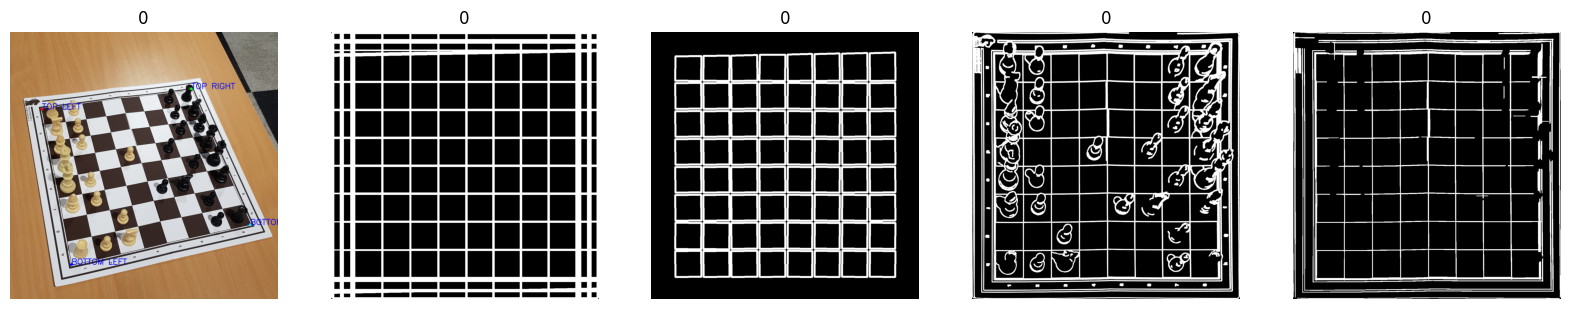

In [145]:
threshold = 0
width, height = (1200, 1200)
corners_list = [np.float32([candidate[2], candidate[1], candidate[3], candidate[0]]) for candidate in candidates]
plot_width = 5
plot_height = len(corners_list)


dst_pts = np.float32([
    [threshold, threshold], 
    [width + threshold, threshold], 
    [threshold, height + threshold], 
    [width + threshold, height + threshold]
])

print("Candidati", len(candidates))
plt.figure(figsize=(10 * plot_height * 2, 10 * plot_width))
for candidate_idx, corners in enumerate(corners_list):
    # Compute the perspective transform matrix
    M = cv2.getPerspectiveTransform(corners, dst_pts)
    M_inv = cv2.invert(M)[1]  # Get the inverse of the perspective matrix

    working_image = cv2.warpPerspective(canny_image, M, (width, height), flags=cv2.INTER_LINEAR)

    # hough_dilation_kernel = np.ones((3, 3), np.uint8)
    # lines = cv2.HoughLinesP(out, 1, np.pi / 180, threshold=500, minLineLength=150, maxLineGap=100)

    # out = cv2.cvtColor(out, cv2.COLOR_GRAY2BGR)
    # if lines is not None:
    #     for line in lines:
    #         x1, y1, x2, y2 = line[0]
    #         # draw only lines to the "black_image"
    #         cv2.line(out, (x1, y1), (x2, y2), (255, 0, 255), 3)

    # Detect horizontal lines
    horizontal_kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (50,1))
    horizontal_mask = cv2.morphologyEx(working_image, cv2.MORPH_OPEN, horizontal_kernel, iterations=1)

    # Detect vertical lines
    vertical_kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (1,50))
    vertical_mask = cv2.morphologyEx(working_image, cv2.MORPH_OPEN, vertical_kernel, iterations=1)
    table_mask = cv2.bitwise_or(horizontal_mask, vertical_mask)
    table_mask = cv2.morphologyEx(table_mask, cv2.MORPH_OPEN, np.ones((3,3)), iterations=1)

    ##### 
    mask_image = np.zeros_like(working_image)
    mask_image[np.where(table_mask==255)] = 255

    # hough_dilation_kernel = np.ones((3, 3), np.uint8)
    lines = cv2.HoughLinesP(working_image, 1, np.pi / 180, threshold=500, minLineLength=width*0.1, maxLineGap=width*0.5)

    hough_image = np.zeros_like(mask_image)
    if lines is not None:
        for line in lines:
            x1, y1, x2, y2 = line[0]
            # draw only lines to the "black_image"
            cv2.line(hough_image, (x1, y1), (x2, y2), (255, 0, 255), 3)


    out = resized.copy()
    best_valid_square_image,_,_,_ = find_best_squares_hough([hough_image], hough_image.shape[0] / parameters_original_size)
    corners = find_best_fitting_enclosing_square(best_valid_square_image)
    if corners is not None:
        #chessboard_approx = cv2.approxPolyN(max_external_contours, 4, False, ensure_convex=True)
        corners = np.array([(corners[2], corners[1], corners[3], corners[0])], dtype=np.float32)
        M_inv = cv2.invert(M)[1]
        corners_original = cv2.perspectiveTransform(corners, M_inv)

        # print(corners_original.shape, corners_original[0].shape, corners_original)
        corners_original_draw = corners_original.astype(int)
        corners_original_draw = [corners_original_draw[0][0], corners_original_draw[0][1], corners_original_draw[0][2], corners_original_draw[0][3]]

        #### OUTPUT
        cv2.circle(out, corners_original_draw[0], 15, (0, 0, 255), -1)  # blue for top-left
        cv2.circle(out, corners_original_draw[1], 15, (0, 255, 0), -1)  # green for top-right
        cv2.circle(out, corners_original_draw[2], 15, (255, 0, 0), -1)  # red for bottom-left
        cv2.circle(out, corners_original_draw[3], 15, (255, 255, 0), -1)  # yellow for bottom-right
        

        cv2.putText(out, "TOP LEFT", corners_original_draw[0], cv2.FONT_HERSHEY_SIMPLEX, 3, (255,0,0), 5, cv2.LINE_AA)
        cv2.putText(out, "TOP RIGHT", corners_original_draw[1], cv2.FONT_HERSHEY_SIMPLEX, 3, (255,0,0), 5, cv2.LINE_AA)
        cv2.putText(out, "BOTTOM LEFT", corners_original_draw[2], cv2.FONT_HERSHEY_SIMPLEX, 3, (255,0,0), 5, cv2.LINE_AA)
        cv2.putText(out, "BOTTOM RIGHT", corners_original_draw[3], cv2.FONT_HERSHEY_SIMPLEX, 3, (255,0,0), 5, cv2.LINE_AA)

    plt.subplot(plot_height, plot_width, candidate_idx*plot_width + 1)
    plt.imshow(out[:,:,::-1])
    plt.title(f"{candidate_idx}")
    plt.axis('off')
    plt.subplot(plot_height, plot_width, candidate_idx*plot_width + 2)
    plt.imshow(hough_image, cmap="gray")
    plt.title(f"{candidate_idx}")
    plt.axis('off')
    plt.subplot(plot_height, plot_width, candidate_idx*plot_width + 3)
    plt.imshow(best_valid_square_image, cmap="gray")
    plt.title(f"{candidate_idx}")
    plt.axis('off')
    plt.subplot(plot_height, plot_width, candidate_idx*plot_width + 4)
    plt.imshow(working_image, cmap="gray")
    plt.title(f"{candidate_idx}")
    plt.axis('off')
    plt.subplot(plot_height, plot_width, candidate_idx*plot_width + 5)
    plt.imshow(mask_image, cmap="gray")
    plt.axis('off')
    plt.title(f"{candidate_idx}")

## TEST TROVARE QUADRATI

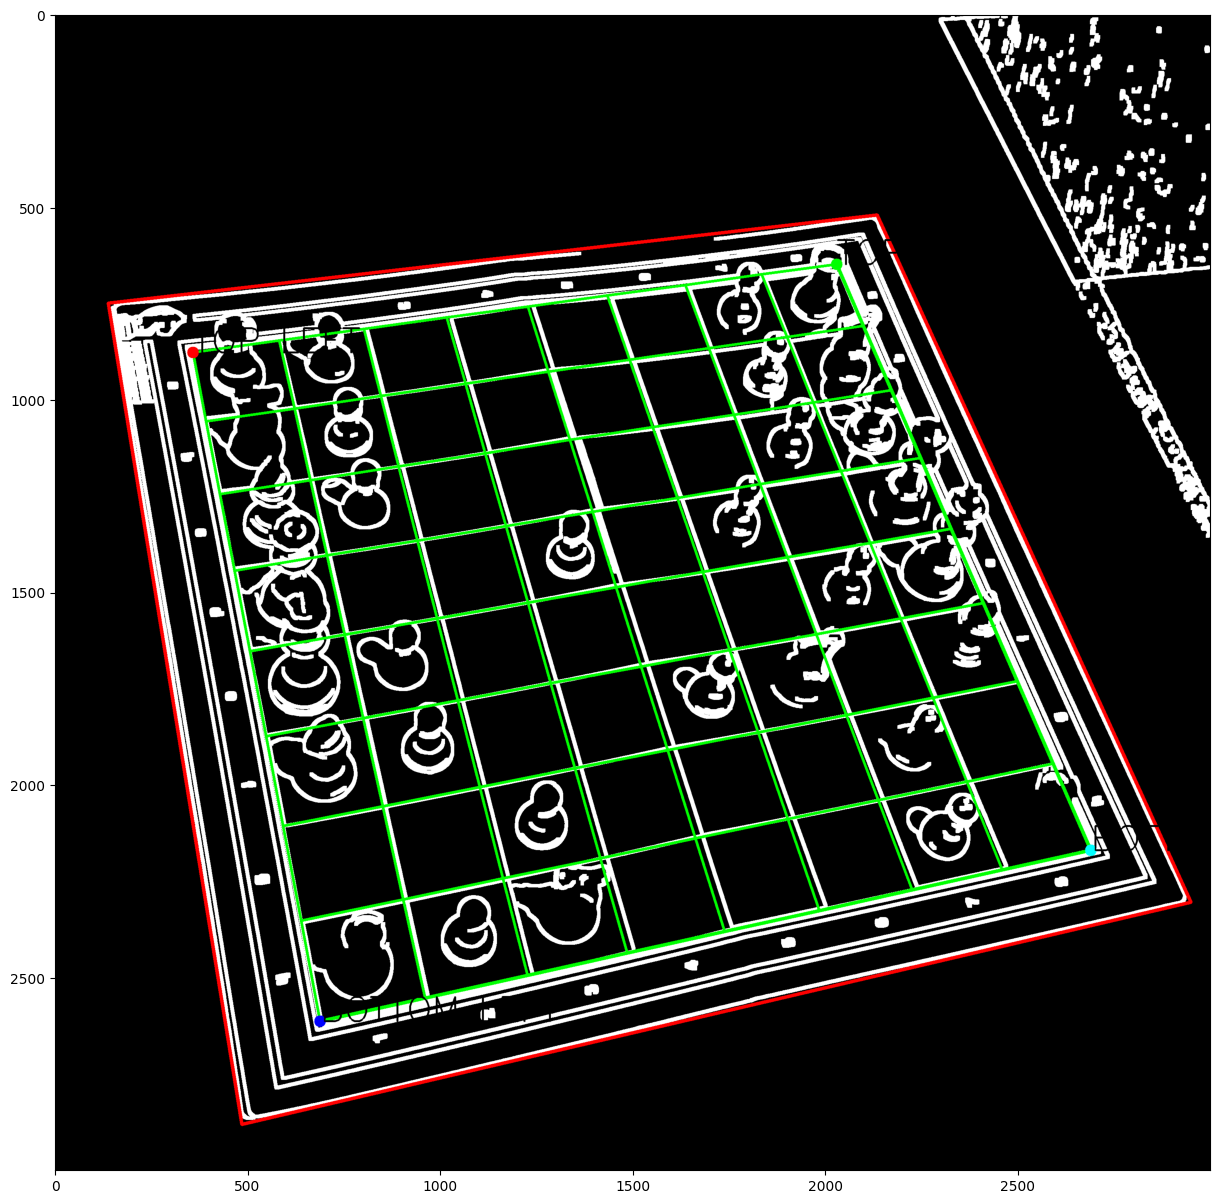

In [ ]:
chessboard_rows, chessboard_cols = 8, 8  # 8x8 chessboard
def find_chessboard_squares(corners, threshold = 0, size = (1200, 1200)):
    '''
    :param corners (top_left, top_right, bottom_left, bottom_right)
    :param threshold extra space on all sides
    :param size tuple
    '''
    width, height = size 

    # Define the destination points (shifted by 'threshold' on all sides)
    dst_pts = np.float32([
        [threshold, threshold], 
        [width + threshold, threshold], 
        [threshold, height + threshold], 
        [width + threshold, height + threshold]
    ])

    # Compute the perspective transform matrix
    M = cv2.getPerspectiveTransform(corners, dst_pts)
    M_inv = cv2.invert(M)[1]  # Get the inverse of the perspective matrix

    # Calculate the width and height of each square in the warped image
    square_width = width // chessboard_cols
    square_height = height // chessboard_rows

    # List to store squares' data in the correct order (bottom-left first)
    squares_data_warped = []
    for i in range(chessboard_rows - 1, -1, -1):  # Start from bottom row and move up
        for j in range(chessboard_cols):  # Left to right order
            # Define the 4 corners of each square
            top_left = (j * square_width, i * square_height)
            top_right = ((j + 1) * square_width, i * square_height)
            bottom_left = (j * square_width, (i + 1) * square_height)
            bottom_right = ((j + 1) * square_width, (i + 1) * square_height)

            # Calculate center of the square
            x_center = (top_left[0] + bottom_right[0]) // 2
            y_center = (top_left[1] + bottom_right[1]) // 2

            # Append to list in the correct order
            squares_data_warped.append([
                (x_center, y_center),
                bottom_right,
                top_right,
                top_left,
                bottom_left
            ])

    # Convert to numpy array for transformation
    squares_data_warped_np = np.array(squares_data_warped, dtype=np.float32).reshape(-1, 1, 2)

    # Transform all points back to the original image
    squares_data_original_np = cv2.perspectiveTransform(squares_data_warped_np, M_inv)

    # Reshape back to list format
    squares_data_original = squares_data_original_np.reshape(-1, 5, 2)  # (num_squares, 5 points, x/y)
    return squares_data_original

def draw_chessboard_corners(corners, image, text_color = (0, 0, 0)):
    corners = corners.astype(int)
    cv2.circle(image, corners[0], 15, (0, 0, 255), -1)  # blue for top-left
    cv2.circle(image, corners[1], 15, (0, 255, 0), -1)  # green for top-right
    cv2.circle(image, corners[2], 15, (255, 0, 0), -1)  # red for bottom-left
    cv2.circle(image, corners[3], 15, (255, 255, 0), -1)  # yellow for bottom-right

    cv2.putText(image, "TOP LEFT", corners[0], cv2.FONT_HERSHEY_SIMPLEX, 3, text_color, 2, cv2.LINE_AA)
    cv2.putText(image, "TOP RIGHT", corners[1], cv2.FONT_HERSHEY_SIMPLEX, 3, text_color, 2, cv2.LINE_AA)
    cv2.putText(image, "BOTTOM LEFT", corners[2], cv2.FONT_HERSHEY_SIMPLEX, 3, text_color, 2, cv2.LINE_AA)
    cv2.putText(image, "BOTTOM RIGHT", corners[3], cv2.FONT_HERSHEY_SIMPLEX, 3, text_color, 2, cv2.LINE_AA)
    return image

def draw_chessboard_squares(image: cv2.typing.MatLike, squares, corners, color=(0,255,0), text_color = (0, 0, 0), thickness=8):
    for idx, square in enumerate(squares):
        x_center, y_center = tuple(map(int, square[0]))  # Convert to int

        bottom_right = tuple(map(int, square[1]))
        top_right = tuple(map(int, square[2]))
        top_left = tuple(map(int, square[3]))
        bottom_left = tuple(map(int, square[4]))

        # Draw necessary lines only (to form grid)
        cv2.line(image, top_left, top_right, (0, 255, 0), 6)  # Top line
        cv2.line(image, top_left, bottom_left, (0, 255, 0), 6)  # Left line

        # Draw bottom and right lines only for last row/column
        i = idx // chessboard_rows
        j = idx % chessboard_cols

        if idx % chessboard_cols == chessboard_cols - 1:
            cv2.line(image, top_right, bottom_right, (0, 255, 0), 8)  # Right line
        if i == 0:
            cv2.line(image, bottom_left, bottom_right, (0, 255, 0), 8)  # Bottom line

        if corners is not None:
            # Mark the extreme points
            draw_chessboard_corners(corners, image, text_color)

square_image = resized.copy()
squares = find_chessboard_squares(corners_original.reshape(1, 4, 2))
draw_chessboard_squares(square_image, squares, corners_original.astype(int)[0], (255, 0, 255))

plt.figure(figsize=(20,15))
plt.imshow(square_image[:,:,::-1])